In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 

In [2]:
if not 'RESULTS_ROOT' in locals():
  # RESULTS_ROOT = 'results/'
  RESULTS_ROOT = 'F:/thesis-cyborg-plants/results/fixed_predawn_7days_jun_jul_aug/'


if not 'EXPERIMENT' in locals():
  # EXPERIMENT = 'gdc_can1_grapevine'
  # EXPERIMENT = 'gdc_can2_grapevine'
  # EXPERIMENT = 'gdc_can3_grapevine'

  # EXPERIMENT = 'gdc_can1_grapevine_no_deficit'
  # EXPERIMENT = 'gdc_can2_grapevine_no_deficit'
  # EXPERIMENT = 'gdc_can3_grapevine_no_deficit'

  # EXPERIMENT = 'gdc_can1_grapevine_10_days_no_deficit'
  # EXPERIMENT = 'gdc_can2_grapevine_10_days_no_deficit'
  # EXPERIMENT = 'gdc_can3_grapevine_10_days_no_deficit'
  # EXPERIMENT = 
  EXPERIMENT = 'fixed_predawn_7days_jun_jul_aug_0'


In [3]:
INPUT_VARIABLES = ['Tac', 'hs', 'u', 'Rg']

INPUT_DESCS = {
    'Tac': 'Air temperature (Celsius)',
    'hs': 'Relative humidity (%)',
    'u': 'Wind speed (m/s)',
    'Rg': 'solar radiation (shortwave irradiance)',
}

OUTPUT_VARIABLES = ['An', 'E', 'Rg', 'Tleaf']

OUTPUT_DESCS = {
    'time': 'simulation time',
    'An': 'Net carbon assimilation flux of whole plant ($\\mu mol s^{-1}$)',
    'E': 'Transpiration flux of whole plant ($g h^{-1}$)',
    'Rg': 'Absorbed shortwave irradiance by whole plant ($W m_{ground}^{-2}$)',
    'Tleaf': 'Median leaf temperature (degrees Celsius)'
}

In [4]:
from pathlib import Path

figure_path = os.path.join(RESULTS_ROOT, 'figures/', EXPERIMENT)
Path(figure_path).mkdir(parents=True, exist_ok=True)

### Loading experiment data

In [5]:
# Loading environmental inputs
import os

experiment_path = os.path.join(RESULTS_ROOT, EXPERIMENT)
env_input = pd.read_csv(os.path.join(experiment_path, 'env_input.csv'))

env_input['time'] = pd.to_datetime(env_input['time'], format='%Y-%m-%d %H:%M:%S')

In [6]:
# Loading plant-level outputs
plant_output = pd.read_csv(os.path.join(experiment_path, 'plant_outputs.csv'))
plant_output['time'] = pd.to_datetime(plant_output['time'], format='%Y-%m-%d %H:%M:%S')

In [7]:
# Filter the environmental inputs to the time range in the experiment
start = plant_output['time'].iloc[0]
end = plant_output['time'].iloc[-1]
env_input = env_input[(start <= env_input['time']) & (env_input['time'] <= end)]

assert(len(env_input) == len(plant_output))

print(f'Time steps: {len(env_input)}')
print(f'Time range: {start} to {end}')

Time steps: 168
Time range: 2012-06-01 00:00:00 to 2012-06-07 23:00:00


In [8]:
# Loading leaf-level plant state
from pickle import load
with open(os.path.join(experiment_path, 'leaf_data.pickle'), 'rb') as f:
  state_data = load(f)

state_variables = sorted(list(state_data.keys()))
vertex_ids = list(state_data[state_variables[0]].keys())

print(f'Available state variables: {state_variables}')
print(f'State size: {len(vertex_ids)}')
assert(len(state_data[state_variables[0]][vertex_ids[0]]) == len(env_input))

Available state variables: ['An', 'Ci', 'E', 'Eabs', 'Ei', 'Flux', 'FluxC', 'Tlc', 'gb', 'gs', 'par_photo.dHd', 'psi_head', 'u']
State size: 360


### Visualize input data and plant-level outputs

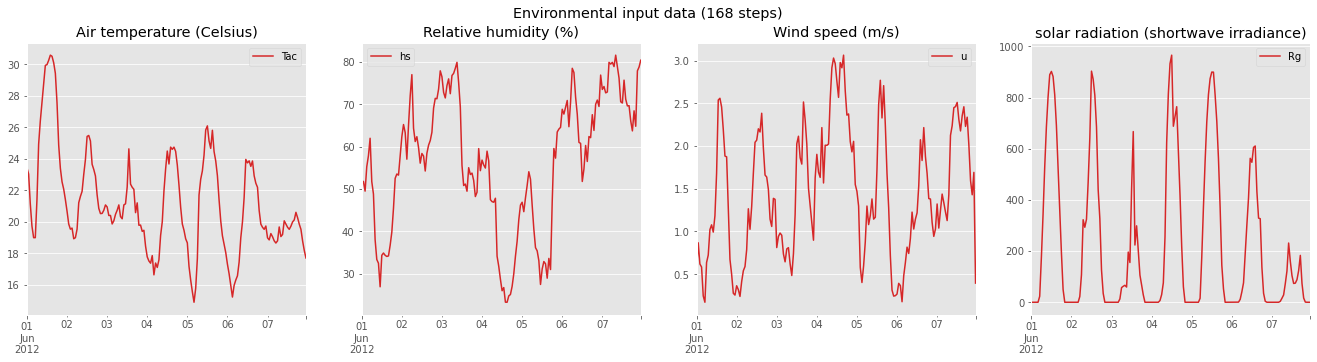

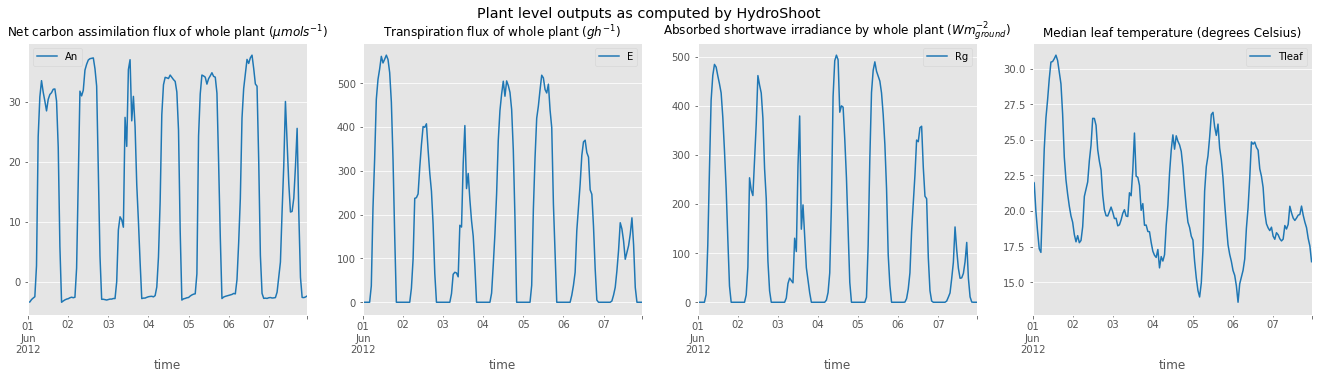

In [9]:
with plt.style.context('ggplot'):
  fig, ax = plt.subplots(1, 4, figsize=(23, 5))
  for i, col in enumerate(INPUT_VARIABLES):
    env_input.plot(x='time', y=col, title=INPUT_DESCS[col], ax=ax[i], c='tab:red', xlabel='')
  fig.suptitle(f'Environmental input data ({len(env_input)} steps)\n', size='x-large')
  plt.savefig(os.path.join(figure_path, f'{EXPERIMENT}_env_inputs.png'), dpi=200)
  plt.show()

  fig, ax = plt.subplots(1, 4, figsize=(23, 5))
  for i, col in enumerate(OUTPUT_VARIABLES):
    plant_output.plot(x='time', y=col, ax=ax[i], c='tab:blue')
    ax[i].set_title(OUTPUT_DESCS[col], size='large')
  fig.suptitle(f'Plant level outputs as computed by HydroShoot\n', size='x-large')
  plt.savefig(os.path.join(figure_path, f'{EXPERIMENT}_plant_outputs.png'), dpi=200)
  plt.show()

  # for i, (name, col) in enumerate(data[['An', 'E', 'Rg', 'Tleaf']].iteritems()):
  #     col.plot(x=data['time'], title=col_descs[name], ax=ax[i//2][i%2])

### Visualize plant state variables

In [27]:
STATE_SIZE = 16

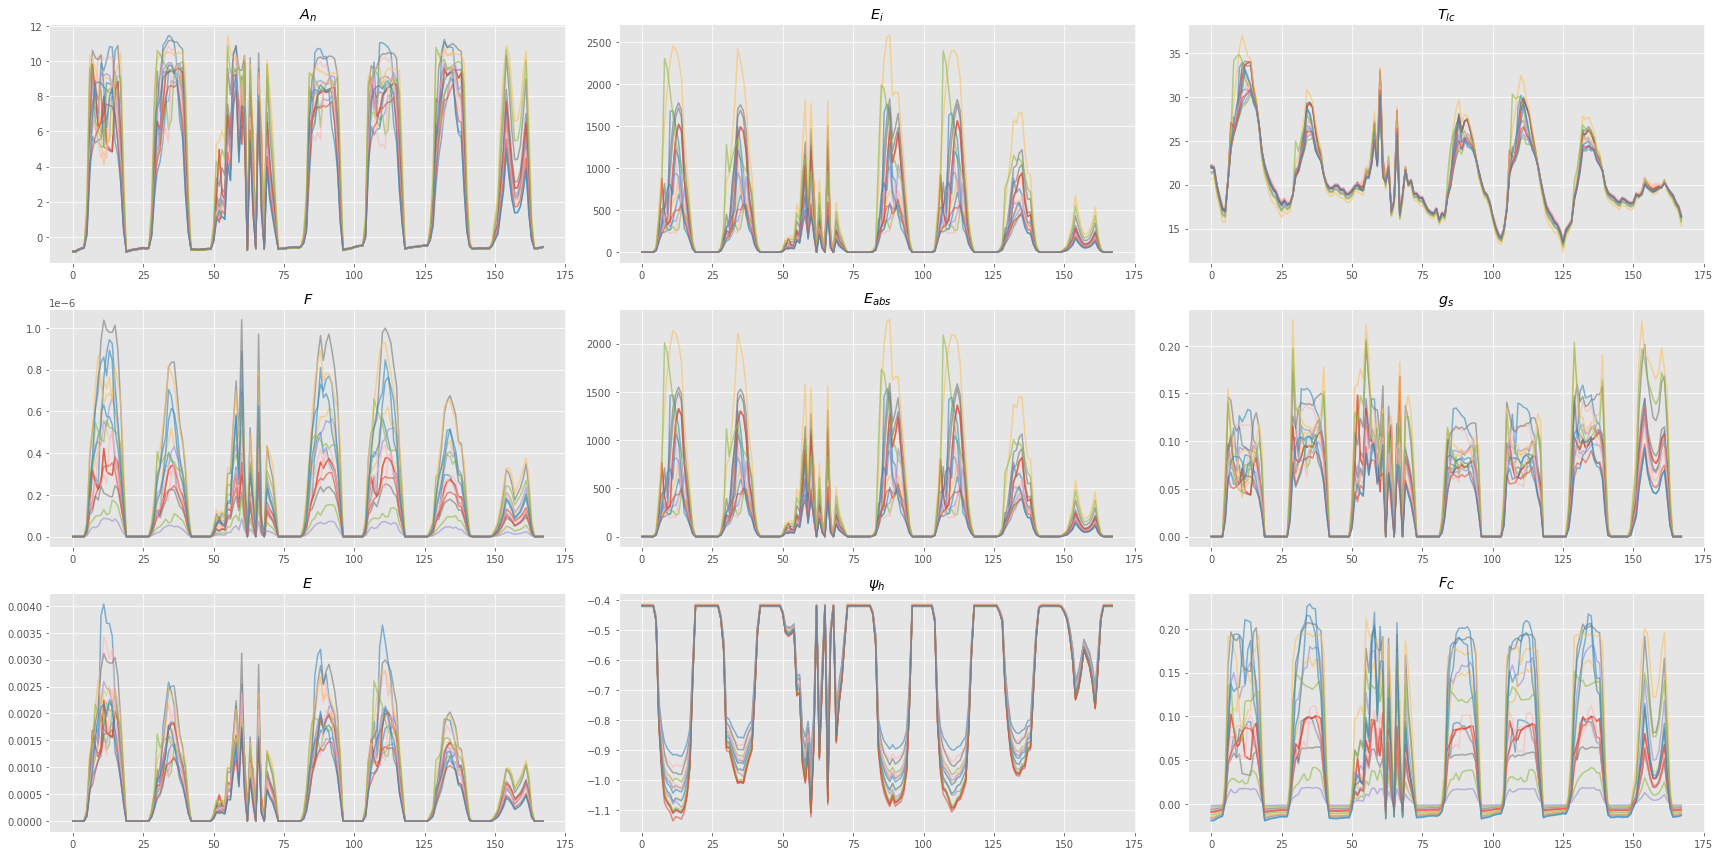

In [34]:
from util import VARIABLE_NAMES

def plot_properties_for_vertices(data, properties, vertex_ids, ncols=4, alpha=0.6):
    cols = min(len(properties), ncols)
    rows = int(np.ceil(len(properties) / cols))
    with plt.style.context('ggplot'):
        fig, axs = plt.subplots(rows, cols, figsize=(24, 4 * rows), squeeze=False)
        for i, var in enumerate(properties):
            row = i // cols;
            col = i % cols;
            vertices = state_data[var]
            for vid in vertex_ids:
                series = vertices[vid]
                axs[row][col].plot(series, alpha=alpha)
                axs[row][col].set_title(VARIABLE_NAMES[var])
        # fig.suptitle(f'Some properties for {len(vertex_ids)} randomly chosen leaves', size='xx-large')
        plt.savefig(os.path.join(figure_path, f'{EXPERIMENT}_state_variables.png'), dpi=200)
        plt.tight_layout()
        plt.show()
        
# Select a random subset of leaves to represent 
# the observable reservoir state (out of 360)
np.random.seed(42)

plot_variables = ['An', 'Ei', 'Tlc',
                              'Flux', 'Eabs', 'gs', 'E',  'psi_head', 'FluxC']

state_ids = np.random.choice(vertex_ids, STATE_SIZE)
plot_properties_for_vertices(state_data, plot_variables, state_ids, alpha=0.6, ncols=3)

### Visualize correlation between leaf state and (i) environmental inputs, (ii) plant-level output 

In [12]:
def plot_correlation_matrix(M, row_labels, col_labels, title, **kwargs):
    figsize = (16, 4) if 'figsize' not in kwargs else kwargs['figsize']
    cmap = 'coolwarm' if 'cmap' not in kwargs else kwargs['cmap']
    fig, ax = plt.subplots(figsize=figsize)

    img = ax.imshow(M, cmap=cmap)
    for (col, row), value in np.ndenumerate(M):
        ax.text(row, col, f'{value:.2f}', ha='center', va='center')

    ax.set_xticks(np.arange(len(col_labels)))    
    ax.set_xticklabels(col_labels)
    ax.set_yticks(np.arange(len(row_labels)))    
    ax.set_yticklabels(row_labels)

    ax.set_title(title)
    plt.colorbar(img)

    if 'path' in kwargs:
        plt.savefig(kwargs['path'], dpi=200, facecolor='white')

    plt.show()


In [13]:
from scipy.stats import pearsonr

correlation_variables = sorted(['An', 'Ei', 'u', 'Tlc', 'Flux', 'Eabs', 'gs', 'E', 'gb', 'psi_head', 'FluxC'])

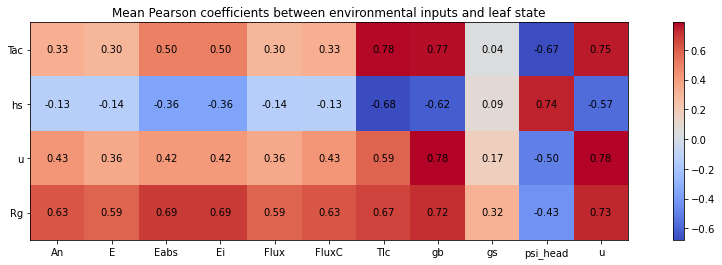

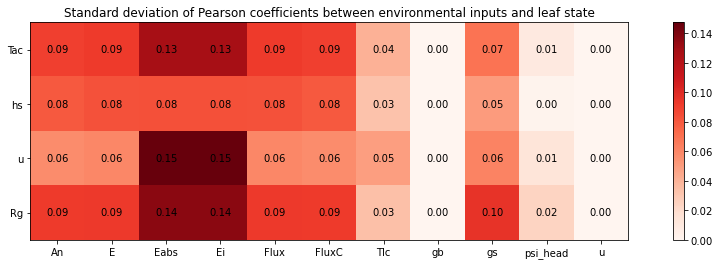

In [14]:
corr_matrix_input_vs_leafs = np.zeros((len(vertex_ids), len(INPUT_VARIABLES), len(correlation_variables)), dtype=float)

for row, input_var in enumerate(INPUT_VARIABLES):
    x = env_input[input_var].to_numpy()
    for col, var in enumerate(correlation_variables):
        for i, vid in enumerate(vertex_ids):
            y = np.array(state_data[var][vid])
            r, _ = pearsonr(x, y)
            corr_matrix_input_vs_leafs[i, row, col] = r
        
corr_matrix_means = corr_matrix_input_vs_leafs.mean(axis=0).reshape((len(INPUT_VARIABLES), len(correlation_variables)))
corr_matrix_stdevs = corr_matrix_input_vs_leafs.std(axis=0).reshape((len(INPUT_VARIABLES), len(correlation_variables)))

plot_correlation_matrix(corr_matrix_means, INPUT_VARIABLES, correlation_variables, 
    'Mean Pearson coefficients between environmental inputs and leaf state',
    path=os.path.join(figure_path, f'{EXPERIMENT}_correlation_input_mean.png'))


plot_correlation_matrix(corr_matrix_stdevs, INPUT_VARIABLES, correlation_variables, 
    'Standard deviation of Pearson coefficients between environmental inputs and leaf state', cmap='Reds',
    path=os.path.join(figure_path, f'{EXPERIMENT}_correlation_input_stdev.png'))


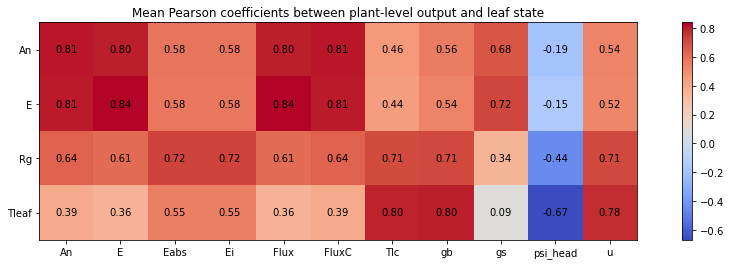

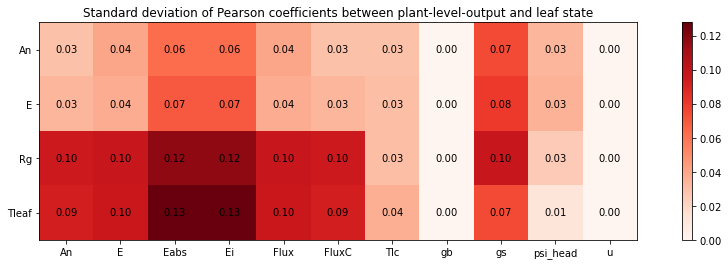

In [15]:
corr_matrix_input_vs_output = np.zeros((len(vertex_ids), len(OUTPUT_VARIABLES), len(correlation_variables)), dtype=float)

for row, output_var in enumerate(OUTPUT_VARIABLES):
    x = plant_output[output_var].to_numpy()
    for col, var in enumerate(correlation_variables):
        for i, vid in enumerate(vertex_ids):
            y = np.array(state_data[var][vid])
            r, _ = pearsonr(x, y)
            corr_matrix_input_vs_output[i, row, col] = r
        
corr_matrix_means = corr_matrix_input_vs_output.mean(axis=0).reshape((len(OUTPUT_VARIABLES), len(correlation_variables)))
corr_matrix_stdevs = corr_matrix_input_vs_output.std(axis=0).reshape((len(OUTPUT_VARIABLES), len(correlation_variables)))

plot_correlation_matrix(corr_matrix_means, OUTPUT_VARIABLES, correlation_variables, 
    'Mean Pearson coefficients between plant-level output and leaf state', cmap='coolwarm',
    path=os.path.join(figure_path, f'{EXPERIMENT}_correlation_output_mean.png'))


plot_correlation_matrix(corr_matrix_stdevs, OUTPUT_VARIABLES, correlation_variables, 
    'Standard deviation of Pearson coefficients between plant-level-output and leaf state', cmap='Reds',
    path=os.path.join(figure_path, f'{EXPERIMENT}_correlation_output_stdev.png'))
